In [1]:
from scipy.io import loadmat
from neuralop.models import FNO, TFNO
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
if torch.cuda.is_available():
    # Set the default device to CUDA
    device = torch.device('cuda')
    #torch.set_default_device(device)
    print('Using CUDA for tensor operations')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for tensor operations')

Using CUDA for tensor operations


In [3]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [4]:
NavierStokes_mat = loadmat('NavierStokes_V1e-5_N1200_T20.mat')

In [5]:
# Assuming NavierStokes_mat['u'] and NavierStokes_mat['a'] are numpy arrays
u_numpy = NavierStokes_mat['u']
a_numpy = NavierStokes_mat['a']

# Convert numpy arrays to PyTorch tensors
u_tensor = torch.tensor(u_numpy)
a_tensor = torch.tensor(a_numpy)

# Concatenate along the desired dimension
concatenated_tensor = torch.cat((u_tensor[:,:,:,:10], a_tensor.unsqueeze(-1)), dim=-1).permute(0, 3, 1, 2).to(device)
result_tensor = u_tensor[:,:,:,:10].permute(0, 3, 1, 2).to(device)

In [6]:
operator = FNO(n_modes=(16, 16), hidden_channels=64,
                in_channels=21, out_channels=1)

In [7]:
# Assuming you have concatenated_tensor as x_data and result_tensor as y_data
my_dataset = CustomDataset(concatenated_tensor, result_tensor)

In [8]:
u_tensor[0].shape

torch.Size([64, 64, 20])

In [9]:
def animate_tensor(tensor_data):
    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.close()  # We'll be using FuncAnimation, so we don't want the initial figure to show up

    # Define the update function for the animation
    def update(frame):
        ax.clear()
        ax.imshow(tensor_data[:, :, frame], cmap='viridis')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=tensor_data.shape[2], interval=100)

    # Display the animation in IPython
    return HTML(ani.to_html5_video())

In [10]:
animate_tensor(u_tensor[0])

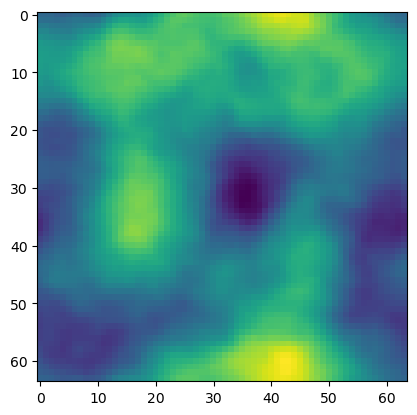

In [11]:
plt.imshow(a_tensor[0])

In [12]:
# Define your DataLoader
batch_size = 64  # Adjust batch size as needed
train_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Define your training parameters
learning_rate = 0.001
num_epochs = 2000  # Adjust as needed

#train_loader = data_loader
#test_loader = data_loader

# Initialize your model
model = TFNO(n_modes=(32, 32), in_channels=11, out_channels = 10, hidden_channels=64, projection_channels=128).to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0

    # Iterate over batches
    for batch_data, batch_targets in train_loader:
        # Move data to device
        batch_data, batch_targets = batch_data.to(device), batch_targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_data)

        # Compute the loss
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
        # Print the loss for each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.8e} ')

print('Finished Training')

Epoch [10/2000], Training Loss: 8.96884251e-03 
Epoch [20/2000], Training Loss: 4.16269555e-03 
Epoch [30/2000], Training Loss: 2.62010716e-03 
Epoch [40/2000], Training Loss: 1.55554664e-03 
Epoch [50/2000], Training Loss: 1.36837508e-03 
Epoch [60/2000], Training Loss: 1.09272878e-03 
Epoch [70/2000], Training Loss: 7.73068612e-04 
Epoch [80/2000], Training Loss: 6.34691323e-04 
Epoch [90/2000], Training Loss: 5.92372840e-04 
Epoch [100/2000], Training Loss: 4.98422179e-04 
Epoch [110/2000], Training Loss: 6.91237951e-04 
Epoch [120/2000], Training Loss: 5.87595503e-04 
Epoch [130/2000], Training Loss: 5.67654809e-04 
Epoch [140/2000], Training Loss: 3.71342390e-04 
Epoch [150/2000], Training Loss: 3.10441686e-04 
Epoch [160/2000], Training Loss: 6.97274942e-04 
Epoch [170/2000], Training Loss: 2.80935558e-04 
Epoch [180/2000], Training Loss: 2.80342336e-04 
Epoch [190/2000], Training Loss: 2.68718158e-04 
Epoch [200/2000], Training Loss: 3.66131420e-04 
Epoch [210/2000], Training Lo

In [14]:
def animate_tensor_predicted(y_tensor, y_predicted):
    # Create a figure and axis with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.close()  # We'll be using FuncAnimation, so we don't want the initial figure to show up

    # Define the update function for the animation
    def update(frame):
        ax1.clear()
        ax2.clear()
        ax1.imshow(y_tensor[:, :, frame], cmap='viridis')
        ax1.set_title('True')
        ax2.imshow(y_predicted[:, :, frame], cmap='viridis')
        ax2.set_title('Predicted')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=y_tensor.shape[2], interval=100)

    # Display the animation in IPython
    return HTML(ani.to_html5_video())

In [17]:
trained_example = model(concatenated_tensor[0].unsqueeze(0)).squeeze(0).permute(1, 2, 0)
animate_tensor_predicted(result_tensor[0].permute(1, 2, 0).cpu(), trained_example.cpu().detach())